In [238]:
import os
import re
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils import Bunch
import joblib

In [239]:
reviews_df = pd.read_csv("C:/Users/HP/Downloads/imdb_reviews.csv")
movies_df = pd.read_csv("C:/Users/HP/Downloads/imdb_list.csv")

print(reviews_df.head())
print(movies_df.head())


     imdb_id                                       review title  \
0  tt0369610  Spielberg Magic, This Is Not. Still, a Visit t...   
1  tt0369610  Not a patch on the original Jurassic Park, and...   
2  tt0369610                    Its a Jurassic World after all.   
3  tt0369610  Worthy Sequel To One Of The Greatest Films Eve...   
4  tt0369610  Manages to somewhat return the Jurassic Park s...   

   review_rating                                             review  
0            7.0  You may have heard some critics champion Juras...  
1            7.0  The original Jurassic Park still is a personal...  
2            7.0  The 4th film in the Jurassic Park series and t...  
3            NaN  Let's start this by stating how much of a die ...  
4            6.0  Modernized and polished entry to the Jurassic ...  
   Unnamed: 0         id                               title  rating  \
0           0  tt0369610                      Jurassic World     6.9   
1           1  tt3774694         

In [240]:
# Check column names first
print("Columns in dataset:", reviews_df.columns)

Columns in dataset: Index(['imdb_id', 'review title', 'review_rating', 'review'], dtype='object')


In [241]:
print("Reviews columns:", list(reviews_df.columns))
print("Movies columns :", list(movies_df.columns))
print("Sample reviews:")
print(reviews_df.head(3)[["imdb_id","review title","review_rating","review"]])

Reviews columns: ['imdb_id', 'review title', 'review_rating', 'review']
Movies columns : ['Unnamed: 0', 'id', 'title', 'rating', 'genre', 'year']
Sample reviews:
     imdb_id                                       review title  \
0  tt0369610  Spielberg Magic, This Is Not. Still, a Visit t...   
1  tt0369610  Not a patch on the original Jurassic Park, and...   
2  tt0369610                    Its a Jurassic World after all.   

   review_rating                                             review  
0            7.0  You may have heard some critics champion Juras...  
1            7.0  The original Jurassic Park still is a personal...  
2            7.0  The 4th film in the Jurassic Park series and t...  


In [242]:
#2) Create labels from rating
def make_label(r):
    if pd.isna(r):
        return np.nan
    if r >= 7:
        return 1
    if r <= 4:
        return 0
    return np.nan  # neutral

In [243]:
# Ensure rating is numeric
reviews_df["review_rating"] = pd.to_numeric(reviews_df["review_rating"], errors="coerce")
reviews_df["label"] = reviews_df["review_rating"].apply(make_label)
before = len(reviews_df)
reviews_df = reviews_df.dropna(subset=["label"])
after = len(reviews_df)
print(f"Dropped {before - after} neutral/invalid rows; training on {after} rows.")

Dropped 1907 neutral/invalid rows; training on 4334 rows.


In [244]:
#3) Build the text field

def combine_text(row) -> str:
    title = str(row.get("review title", "")) if pd.notna(row.get("review title", "")) else ""
    body  = str(row.get("review", "")) if pd.notna(row.get("review", "")) else ""
    return (title + " " + body).strip()

reviews_df["text"] = reviews_df.apply(combine_text, axis=1)

In [245]:
# Quick sanity check
print("Example text:", reviews_df["text"].iloc[0][:300], "...")

Example text: Spielberg Magic, This Is Not. Still, a Visit to Jurassic World Is Worth the Price of Admission. You may have heard some critics champion Jurassic World as "The best Jurassic Park sequel", some fans declare that it "brought them back to their childhood", and others who may have made the absurd claim, ...


In [246]:
# 4) Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    reviews_df["text"],
    reviews_df["label"].astype(int),
    test_size=0.2,
    random_state=42,
    stratify=reviews_df["label"].astype(int)
)

In [247]:
# 5) Vectorizer + Model Pipeline
pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        stop_words="english",
        max_features=50000,
        ngram_range=(1,2),
        min_df=2
    )),
    ("logreg", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        n_jobs=None 
    ))
])

pipe.fit(X_train, y_train)


,steps,"[('tfidf', ...), ('logreg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [248]:
# 6) Evaluation
pred = pipe.predict(X_test)
proba = pipe.predict_proba(X_test)[:,1]

print("\nAccuracy:", round(accuracy_score(y_test, pred), 4))
print("\nClassification Report:\n", classification_report(y_test, pred, target_names=["negative","positive"]))

cm = confusion_matrix(y_test, pred)
print("Confusion Matrix [[tn, fp],[fn, tp]]:\n", cm)


Accuracy: 0.9377

Classification Report:
               precision    recall  f1-score   support

    negative       0.69      0.59      0.64        80
    positive       0.96      0.97      0.97       787

    accuracy                           0.94       867
   macro avg       0.82      0.78      0.80       867
weighted avg       0.93      0.94      0.94       867

Confusion Matrix [[tn, fp],[fn, tp]]:
 [[ 47  33]
 [ 21 766]]


In [249]:
# 7) Inspect top features
tfidf = pipe.named_steps["tfidf"]
logreg = pipe.named_steps["logreg"]

feature_names = np.array(tfidf.get_feature_names_out())
coefs = logreg.coef_[0]

top_pos_idx = np.argsort(coefs)[-20:][::-1]
top_neg_idx = np.argsort(coefs)[:20]

print("\nTop POSITIVE features:")
for i in top_pos_idx:
    print(f"{feature_names[i]:<25} {coefs[i]:.3f}")

print("\nTop NEGATIVE features:")
for i in top_neg_idx:
    print(f"{feature_names[i]:<25} {coefs[i]:.3f}")


Top POSITIVE features:
great                     2.501
action                    2.135
fun                       1.986
perfect                   1.799
amazing                   1.672
life                      1.632
best                      1.619
beautiful                 1.591
loved                     1.563
lot                       1.433
watch                     1.392
enjoy                     1.372
fantastic                 1.308
enjoyed                   1.293
performance               1.244
film                      1.194
especially                1.182
performances              1.150
excellent                 1.147
role                      1.104

Top NEGATIVE features:
boring                    -3.754
just                      -3.668
bad                       -2.828
stupid                    -2.442
ridiculous                -2.296
worst                     -2.245
terrible                  -2.223
plot                      -2.025
awful                     -1.969
generic        

In [250]:
 #8)  Merge with metadata and do a quick analysis

meta_df = reviews_df.merge(movies_df.rename(columns={"id":"imdb_id"}), on="imdb_id", how="left")

In [251]:
# 9) Save model & vectorizer
os.makedirs("artifacts", exist_ok=True)
joblib.dump(pipe, "artifacts/sentiment_pipeline.joblib")
print("\nSaved trained pipeline -> artifacts/sentiment_pipeline.joblib")



Saved trained pipeline -> artifacts/sentiment_pipeline.joblib


In [252]:
# 10) Inference helper 
def predict_sentiment(texts):
    """
    texts: list[str] or str
    returns: list of dicts with text and predicted label/proba
    """
    if isinstance(texts, str):
        texts = [texts]
    preds = pipe.predict(texts)
    probs = pipe.predict_proba(texts)[:,1]
    out = []
    for t, p, pr in zip(texts, preds, probs):
        out.append({"text": t, "label": int(p), "proba_positive": float(pr)})
    return out

# Try it
print("\nQuick test:", predict_sentiment("This movie was fantastic, I loved every minute!") )


Quick test: [{'text': 'This movie was fantastic, I loved every minute!', 'label': 1, 'proba_positive': 0.8297758500172745}]


In [253]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

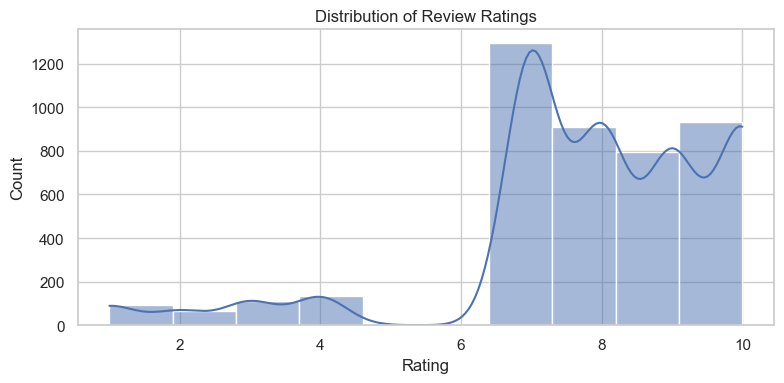

In [254]:
# 1) Distribution of Ratings
plt.figure(figsize=(8, 4))
sns.histplot(reviews_df["review_rating"], bins=10, kde=True)
plt.title("Distribution of Review Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

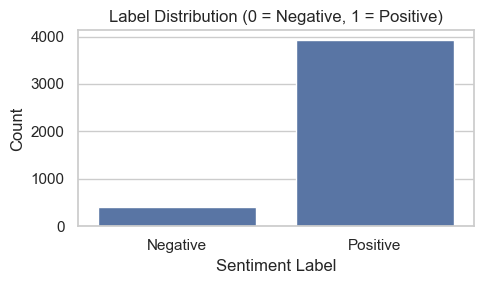

In [255]:
# 2) Sentiment Label Counts
plt.figure(figsize=(5, 3))
sns.countplot(x="label", data=reviews_df)
plt.title("Label Distribution (0 = Negative, 1 = Positive)")
plt.xlabel("Sentiment Label")
plt.ylabel("Count")
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.tight_layout()
plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_11944\4740000.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_pos_scores, y=top_pos_words, palette="Greens_d")


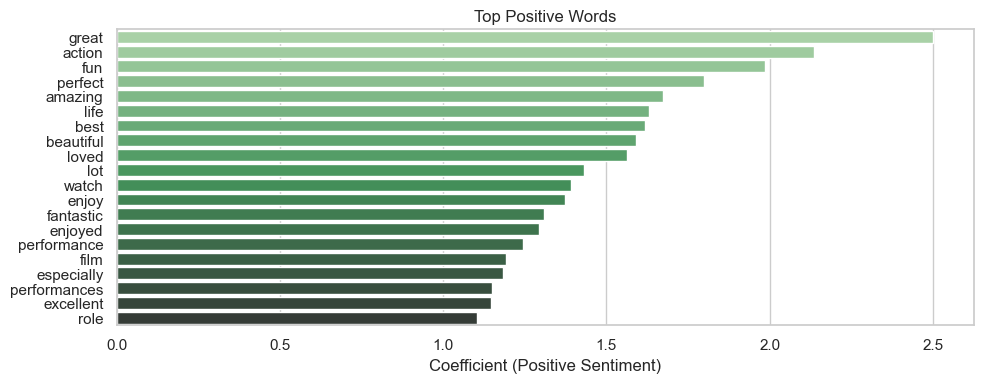

C:\Users\HP\AppData\Local\Temp\ipykernel_11944\4740000.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_neg_scores, y=top_neg_words, palette="Reds_d")


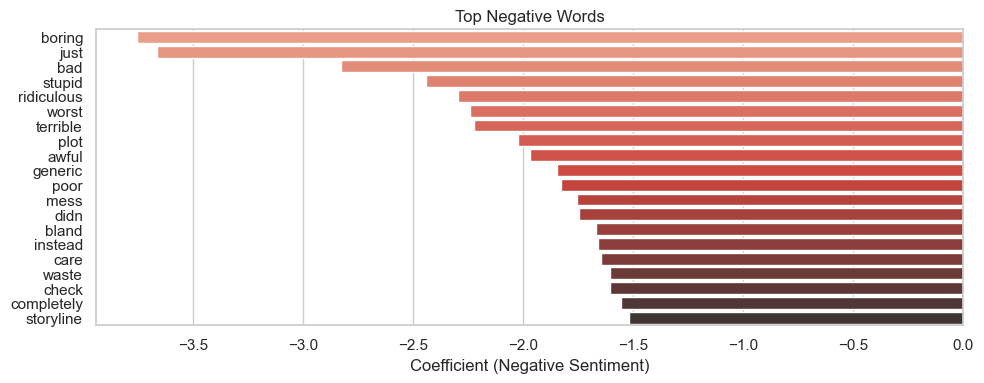

In [256]:
# 3) Top Words by Sentiment
top_pos_words = feature_names[top_pos_idx]
top_neg_words = feature_names[top_neg_idx]
top_pos_scores = coefs[top_pos_idx]
top_neg_scores = coefs[top_neg_idx]

plt.figure(figsize=(10, 4))
sns.barplot(x=top_pos_scores, y=top_pos_words, palette="Greens_d")
plt.title("Top Positive Words")
plt.xlabel("Coefficient (Positive Sentiment)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
sns.barplot(x=top_neg_scores, y=top_neg_words, palette="Reds_d")
plt.title("Top Negative Words")
plt.xlabel("Coefficient (Negative Sentiment)")
plt.tight_layout()
plt.show()